In [57]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sys, tqdm

plt.style.use("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/matplotlib_style/standard_plot_style.mplstyle")

import qutip

save_figures = True
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/spam_seperation_and_post_selection/"

# Load Data and Create Matched Filter

In [58]:
data = pd.read_csv("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/experiments/trace_data/trace_2k_10us_10ns_resolution.csv")
dt   = 10
data.head()

# Simulations:
# data = pd.read_pickle("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/readout_strategies/simulation_data/inbetween_5us_2k.pkl")

,trajectory,initial_state,I,Q,t
0,0,0,0.088654,-0.083207,0
1,0,0,-0.016861,0.007177,10
2,0,0,0.008373,-0.075257,20
3,0,0,0.091618,0.108743,30
4,0,0,-0.070568,0.067275,40


In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

IQ_data         = data.loc[:, ("I", "Q")].values.reshape(2000, -1, 2) # Reshape into trajectory, time, I/Q
initial_state   = data.groupby("trajectory").initial_state.first().values
time            = data.loc[:, "t"].unique()

# Seperate to test and train. 0.75 / 0.25 split 
from sklearn.model_selection import train_test_split
IQ_train, IQ_test, initial_state_train, initial_state_test = train_test_split(IQ_data, initial_state, test_size=0.50, random_state=42)


# Calculate mf weights
def weights(data, target):
    target = initial_state_train

    data_0 = data[target == 0, ...]
    data_1 = data[target == 1, ...]

    weights = (data_0.mean(axis = 0) - data_1.mean(axis = 0)) / (data_0.std(axis = 0) ** 2 + data_1.std(axis = 0) ** 2)
    return weights

weights_for_mf = weights(IQ_train, initial_state_train)
mean_data_train = np.einsum("ijk, jk -> ijk", IQ_train, weights_for_mf).mean(axis = 1)

# Combine to an mf_model providing probabilties from the training set
def mf_model(data, target, interval = (0, np.inf), weights = weights_for_mf, data_train = mean_data_train, target_train = initial_state_train):
    """
    Calculate the mean of the I and Q components of the data in a given interval
    Perform an LDA transformation and return the probabilities for classification
    """
    data = np.einsum("ijk, jk -> ijk", data, weights)

    consider_interval = np.logical_and(time >= interval[0], time <= interval[1])
    mean_data = np.mean(data[:, consider_interval, :], axis = 1)

    lda_model = LDA().fit(mean_data_train, initial_state_train)

    probability_of_excited = lda_model.predict_proba(mean_data)

    return probability_of_excited

# Classify Data

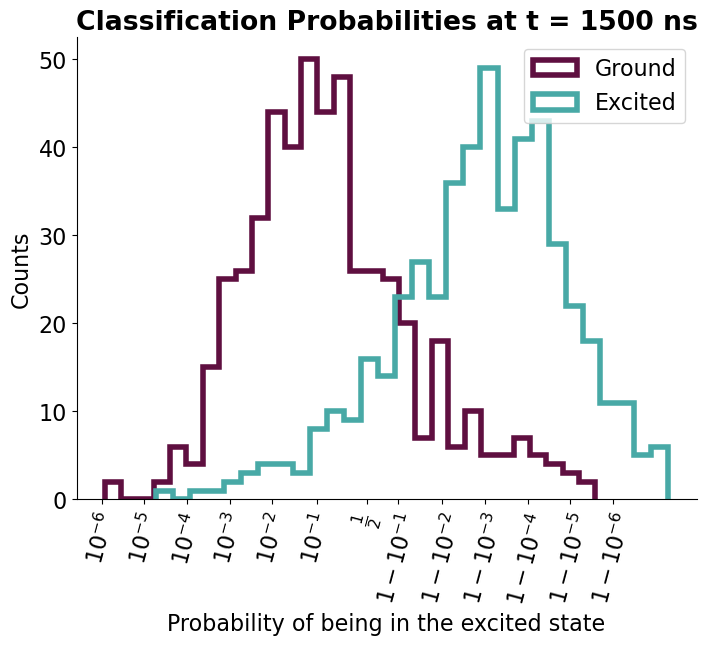

In [60]:
from scipy.special import logit
interval = (0, 1500)
test_probabilities = mf_model(IQ_test, initial_state_test, interval = interval)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

ax.hist(logit(test_probabilities[initial_state_test == 0, 1]), bins = 30, histtype = "step", label = "Ground",  linewidth = 4)
ax.hist(logit(test_probabilities[initial_state_test == 1, 1]), bins = 30, histtype = "step", label = "Excited", linewidth = 4)

label_pos = np.concatenate([logit(10. ** np.arange(-6, 0)), [0.5],  logit(1 - 10. ** np.arange(-6, 0))])
labels_left =  [f"$10^{{{number}}}$" for number in np.arange(-6, 0)]
labels_mid  = [r"$\frac{1}{2}$"]
labels_right = [f"$1 - 10^{{{number}}}$" for number in np.arange(-6, 0)]

ax.set_xticks(label_pos)
ax.set_xticklabels(labels_left + labels_mid + labels_right, rotation = 75)

ax.set(
    xlabel = "Probability of being in the excited state",
    ylabel = "Counts",
    title  = f"Classification Probabilities at t = {interval[1]} ns"
)

ax.legend()

# Fidelity in Post-Selected Samples


In [96]:
from scipy.special import logit
interval = (0, 1000)
test_probabilities = mf_model(IQ_test, initial_state_test, interval = interval)

sorted_idx = np.argsort(test_probabilities.min(axis = 1))

included_data_count = np.arange(50, 1050, 50)
accuracy = np.zeros_like(included_data_count, dtype = float)

for i, include in enumerate(included_data_count):
    include_index = sorted_idx[:include]

    predictions = np.argmax(test_probabilities[include_index, :], axis = 1)

    accuracy[i] = np.mean(predictions == initial_state_test[include_index])

[(0.0, 1.05),
 (0.75, 1.0),
 Text(0.5, 0, 'Fraction of data included'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Accuracy of classification at t = 1000 ns')]

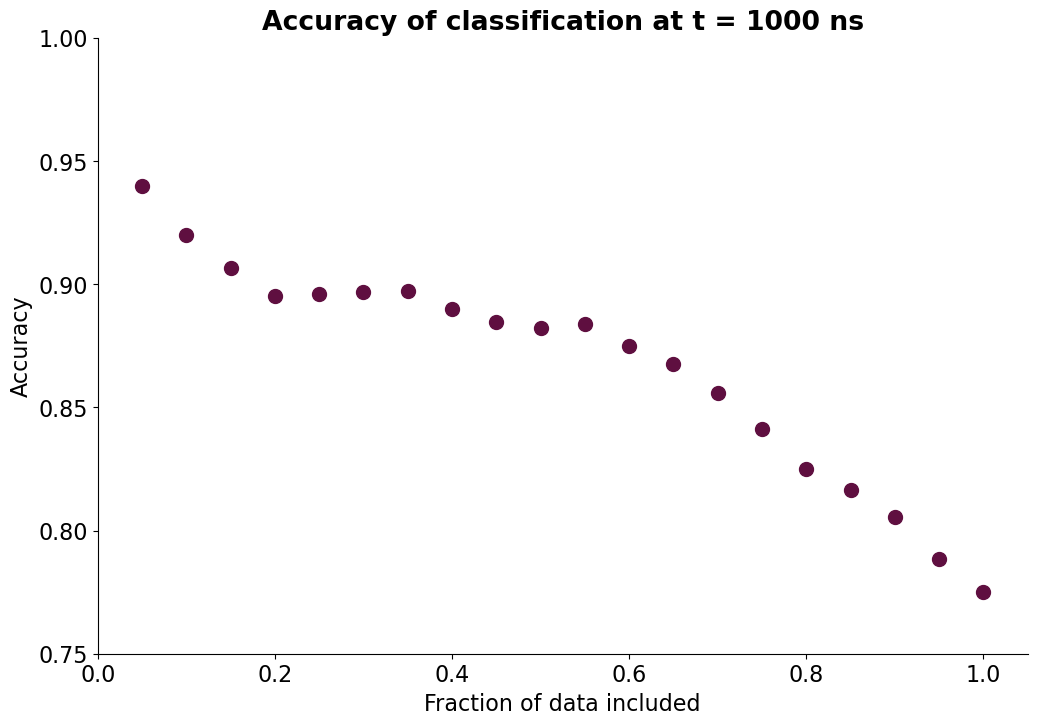

In [97]:
fig, ax = plt.subplots()

ax.plot(included_data_count / len(sorted_idx), accuracy, marker = "o", ls = "None", markersize = 10)

ax.set(
    xlim = (0, 1.05),
    ylim = (0.75, 1),
    xlabel = "Fraction of data included",
    ylabel = "Accuracy",
    title  = f"Accuracy of classification at t = {interval[1]} ns")

In [98]:
interval_ends = np.arange(1000, 5100, 100)
included_data_count = np.arange(50, 1050, 50)

accuracy = np.zeros((len(interval_ends), len(included_data_count)), dtype = float)

for i, interval_end in enumerate(interval_ends):
    test_probabilities = mf_model(IQ_test, initial_state_test, interval = (0, interval_end))
    sorted_idx = np.argsort(test_probabilities.min(axis = 1))
        
    for j, include in enumerate(included_data_count): 
        include_index = sorted_idx[:include]

        predictions = np.argmax(test_probabilities[include_index, :], axis = 1)

        accuracy[i, j] = np.mean(predictions == initial_state_test[include_index])


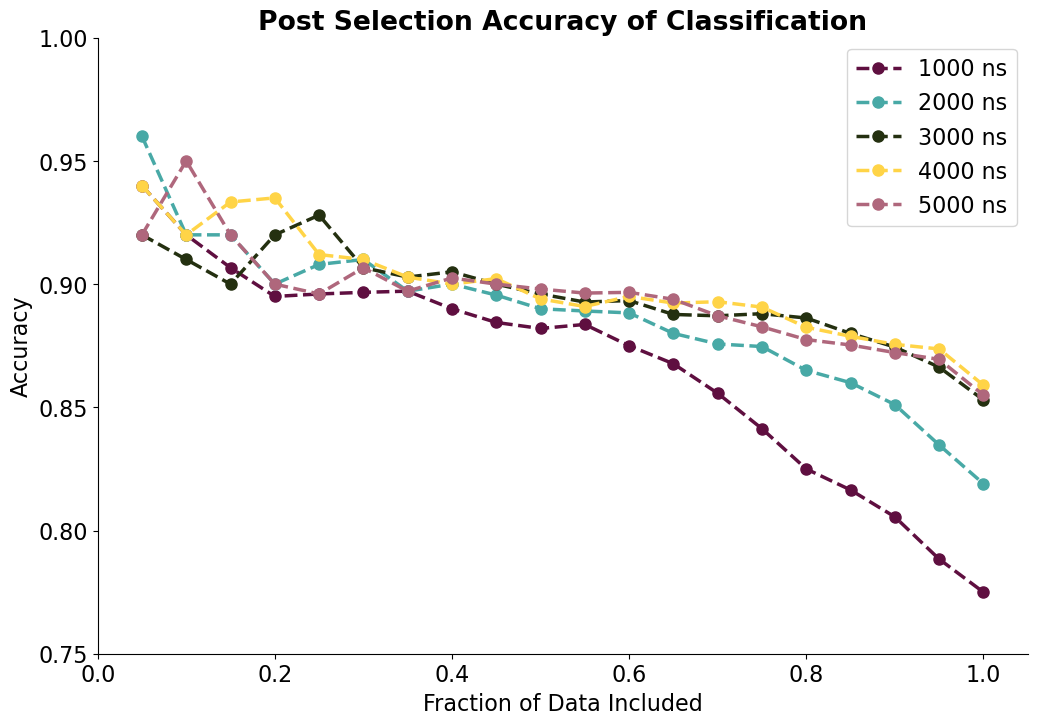

In [115]:
fig, ax = plt.subplots()

for i in range(0, accuracy.shape[0], 10):
    ax.plot(included_data_count / len(sorted_idx), accuracy[i, :], marker = "o", ls = "--", markersize = 8, label = f"{interval_ends[i]} ns")

ax.set(
    xlim = (0, 1.05),
    ylim = (0.75, 1),
    xlabel = "Fraction of Data Included",
    ylabel = "Accuracy",
    title  = f"Post Selection Accuracy of Classification"
) 

ax.legend()